This file is a continuation of Continuous Control in the same folder

The reason I have started a new file is because I wanted to keep the old file as evidence of the work done to get to this point. Otherwise it is the same

# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [6]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [7]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [8]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [9]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print(type(states[0]))

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]
<class 'numpy.ndarray'>


In [10]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment. But note - don't do this if you plan to train the agent. I cannot find a way of re-starting it, other than completely refreshing this notebook. Broken pipe etc. 

In [11]:
# See comments above - don't close the environment. You can always just reset it!
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Proposed approach by DCFW
1. Use a DDPG actor-critic model to train the two agents (actor and critic).
1. Use the Udacity DDPG - pendulum code as a starter code to work with


In [12]:
# first import torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
# also import other required modules
import random
import pickle
import copy
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# define helper function for initialising layers.
# Note, pytorch does this automatically for the first intialisation.
# Note, I believe Udacity code for DDPG pendulum was slightly wrong - used the output features as the basis,
# not the input features. To check out.
def hidden_init(layer):
    """Helper function. Just returns the limits used for weights initialisation in the hidden layer
    """
    f_out, f_in = layer.weight.data.size()
    lim = 1. / np.sqrt(f_in)
    return (-lim, lim)

## Set up the Actor model

In [15]:
# define the Actor. This is the agent that is going to try to learn the best policy
class Actor(nn.Module):
    """Actor (Policy) Model"""
    
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed) # for reproducibility
        self.fc1 = nn.Linear(in_features=state_size, out_features=fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        """reset the weighs of the layer to random uniform distribution (range = sqrt of number of input features)"""
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3) # find out why hard-coded? Same for Critic 
        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) # INVESTIGATE this - whether better activation fn would be useful. tanh
                                    # will map to between -1 and +1

## Demonstrate / test some of the features of the Actor model

In [16]:
# Demo some of the features of the Actor model
actor = Actor(state_size=33, action_size=4, seed=42)
print ('Actor summary:')
print (actor)
print ('\nSummary of second hidden layer')
print (actor.fc2)
print ('\nTorch tensor of the dimensions of second hidden layer:')
print (actor.fc2.weight.data.size())
print ('\nTorch initialises weights uniform random between +- sqrt(number of features in)')
print ('\nTo check whether this is true, the min and max of second hidden layer are:')
print (actor.fc2.weight.data.numpy().min(), actor.fc2.weight.data.numpy().max())
print ('... and the sqrt of number of input features to second hidden layer of {} is:'
       .format(actor.fc2.weight.data.size()[1]))
print (1. / np.sqrt(actor.fc2.weight.data.size()[1]))

state = np.array([np.random.random() for i in range(33)])
print ('\nCreated a random state of the following type (should be numpy array, like the Unity environment will provide)')
print (type(state))
print ('\nOutput from one forward pass of the model - should be tensor of size 4, corresponding to the 4 actions')
print (actor.forward(torch.from_numpy(state).float()))

Actor summary:
Actor(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

Summary of second hidden layer
Linear(in_features=256, out_features=128, bias=True)

Torch tensor of the dimensions of second hidden layer:
torch.Size([128, 256])

Torch initialises weights uniform random between +- sqrt(number of features in)

To check whether this is true, the min and max of second hidden layer are:
-0.0624967 0.0624897
... and the sqrt of number of input features to second hidden layer of 256 is:
0.0625

Created a random state of the following type (should be numpy array, like the Unity environment will provide)
<class 'numpy.ndarray'>

Output from one forward pass of the model - should be tensor of size 4, corresponding to the 4 actions
tensor(1.00000e-02 *
       [ 5.2321, -7.0089, -2.3594, -1.1062])


## Set up the Critic model
The critic is trying to learn the value-action of the state environment rather than the policy.  
This will help speed up the learning rather than trying to learn the policy just on its own.

In [17]:
class Critic(nn.Module):
    """Critic (Value) Model"""
    
    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(in_features=state_size, out_features=fcs1_units)
        # note the difference in output units to input units - we are going to concatenate the actions here
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        """reset the weighs of the layer to random uniform distribution (range = sqrt of number of input features)"""
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        # we now need to add in the actions - why do we not do this at the first layer?
        t_xs = torch.transpose(xs, 0, 1)
        t_action = torch.transpose(action, 0, 1)
        x = torch.transpose(torch.cat((t_xs, t_action)), 0,1) # check whether I need to put in the dimension?
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no need to put through an activation layer, as we want the VALUE of the state-action
        return x

In [18]:
# Examine the Critic model - no need to do the full exploration as for the Actor
c = Critic(state_size=33, action_size=4, seed=42)
print (c)

Critic(
  (fcs1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=260, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [19]:
# create some dummy states and actions to check the forward pass
state = np.random.random((128,33))
state = torch.from_numpy(state).float()

actions = np.random.random((128,4))
actions = torch.from_numpy(actions).float()

# check the forward pass. This should create a scalar value for the state action pair.
out =c.forward(state=state, action=actions)
print (out.shape)

torch.Size([128, 1])


### Identify the device being used. We need to do this in the set up of the main Agent
NOTE - set up and test the model using CPU first, then run training on GPU

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device has been set, it is: {}'.format(device))
if device.type == 'cuda':
    print('We are using GPU for TRAINING')
else:
    print('We are using CPU to set up and test')

device has been set, it is: cuda:0
We are using GPU for TRAINING


## Set up the DEFAULT hyper-parameters
These have been taken from the [Udacity Deep Reinforcement Learning DDPG-pendulum code](ahttps://github.com/udacity/deep-reinforcement-learning), as a starting point to explore the hyper-parameters

In [21]:
BUFFER_SIZE = int(1e5)  # replay buffer size, Udacity_pendulum = 1e5
BATCH_SIZE = 128        # minibatch size, Udacity_pendulum = 128
GAMMA = 0.99            # discount factor, Udacity_pendulum = 0.99
TAU = 1e-3              # for soft update of target parameters, Udacity_pendulum = 1e-3
LR_ACTOR = 1e-4         # learning rate of the actor , Udacity_pendulum = 1e-4
LR_CRITIC = 1e-3        # learning rate of the critic, Udacity_pendulum = 1e-3
WEIGHT_DECAY = 0        # L2 weight decay, Udacity_pendulum = 0

In [22]:
# define OUNoise which is used to add a bit of noise if you want a little
# more exploratory action - you add it to the calculated action vector
class OUNoise:
    """Ornstein-Uhlenbeck process"""
    
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process"""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        
    def reset(self):
        """Reset the internal state (=noise) to mean (mu)"""
        self.state = copy.copy(self.mu)
        
    def sample(self, epsilon=1.0):
        """Update internal state and return it as a noise sample"""
        x = self.state
        dx = self.theta * (self.mu - x) + epsilon* self.sigma * np.array(
#             [random.random() for i in range(len(x))])
            [random.random() -0.5 for i in range(len(x))])
        self.state = x + dx
        return self.state

In [23]:
# demonstrate the funcition of OUNoise
oun = OUNoise(size=(5), seed=101)
print ('Before: {}'.format(oun.state))
print ('After: {}'.format(oun.sample(epsilon=0.5)))

Before: [ 0.  0.  0.  0.  0.]
After: [ 0.00811521 -0.03052455  0.04652511  0.04239764 -0.00328613]


In [24]:
# define the Replay Buffer - re-using paths multiple times
class ReplayBuffer:
    """Fixed size buffer to store experience tuples"""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen= buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=[
            "state", "action", "reward", "next_state", "done" 
        ])
        self.seed = random.seed()
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experinece to the ReplayBuffer memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences
                    if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences
                    if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences 
                    if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences 
                    if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences 
                    if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def len(self):
        """Return the current size of the internal memory"""
        return len(self.memory)

In [25]:
class Agent():
    """Interacts and learns from the environment
    Uses the Actor and Critic in tandem"""
    
    def __init__(self, hypers):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
    
        self.state_size = hypers['state_size']
        self.action_size = hypers['action_size']
        self.seed = hypers['random_seed']
        self.actor_fc1_units = hypers['actor_fc1_units']
        self.actor_fc2_units = hypers['actor_fc2_units']
        self.lr_actor = hypers['lr_actor']
        self.critic_fcs1_units = hypers['critic_fcs1_units']
        self.critic_fc2_units = hypers['critic_fc2_units']
        self.lr_critic = hypers['lr_critic']
        self.weight_decay = hypers['weight_decay']
        self.learn_every = hypers['learn_every']
        self.oun_mu = hypers['oun_mu']
        self.oun_theta = hypers['oun_theta']
        self.oun_sigma = hypers['oun_sigma']
        self.buffer_size = hypers['buffer_size']
        self.batch_size = hypers['batch_size']
        self.gamma = hypers['gamma']
        self.tau = hypers['tau']
        self.learn_counter = 0
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, self.action_size, self.seed, 
                                 self.actor_fc1_units, self.actor_fc2_units ).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, self.seed,
                                 self.actor_fc1_units, self.actor_fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),
                                lr=self.lr_actor)
        
        # Critic Network (w/Target Network)
        self.critic_local = Critic(self.state_size, self.action_size, self.seed,
                                  self.critic_fcs1_units, self.critic_fc2_units).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, self.seed,
                                   self.critic_fcs1_units, self.critic_fc2_units).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),
                                lr=self.lr_critic, weight_decay= self.weight_decay)
        
        # Noise process
        self.noise = OUNoise(self.action_size, self.seed, self.oun_mu, self.oun_theta, self.oun_sigma)
        
        # Replay memory
        self.memory = ReplayBuffer(self.action_size, self.buffer_size, self.batch_size,
                                  self.seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save the experience in the reply memory, and use random
        sample from buffer to learn"""
        # save the experience /reward etc
        self.memory.add(state, action, reward, next_state, done)
        
        # check there are enough samples in memory, and then learn
        if self.memory.len() > self.batch_size and self.learn_counter % self.learn_every ==0:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)
        self.learn_counter +=1
    
    def act(self, state, add_noise=True, epsilon=1.0):
        """Returns actions for a given state as per current policy"""
        state = torch.from_numpy(state).float().to(device)
        # forward pass through the actor neural net to give actions
        self.actor_local.eval()
        # turn off autograd for this one step as it speeds this up (and we don't need it here)
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample(epsilon)
        return np.clip(action, -1, 1) # it is bounded to +/-1
    
    def reset(self):
        self.noise.reset()
    
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # -------------------update critic-----------------------#
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1- dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimise the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # -------------------update actor ------------------------#
        # compute actor loss
        actions_pred = self.actor_local(states)
        # remember - we are doing gradient ASCENT for actor policy
        # so turn it negative and run gradient descent....
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss (=maximise the gain in grad ascent)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # -------------------update target networks --------------#
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(
            target_model.parameters(), local_model.parameters()):
                target_param.data.copy_(tau*local_param.data +
                    (1.0-tau) * target_param.data)
        

We now need to set up the hyper-parameters, because we pass these into the agent at the start.

In [26]:
def set_up_hyperparameters(**kwargs):
    """return a hyper-parameter dictionary to use in training"""
    # populate the dictionary first with the default ones. We will over-write them as we tweak the training.
    hypers = {
        'state_size': 33,
        'action_size': 4,
        'random_seed': 101,
        'buffer_size': BUFFER_SIZE,
        'batch_size': BATCH_SIZE,
        'gamma': GAMMA,
        'tau': TAU,
        'lr_actor': LR_ACTOR,
        'lr_critic': LR_CRITIC,
        'weight_decay': WEIGHT_DECAY,
        'learn_every': 5,
        # now we are onto dcfw 'defaults',
        'n_episodes': 300, # number of episodes - set at 300 to see early results, otherwise need c. 1000
        'max_t': 1000, # this needs to be 1,000, or otherwise set the loop to while True.
        'print_every': 50,
        'oun_mu': 0.,
        'oun_theta': 0.15,
        'oun_sigma': 0.2,
        'actor_fc1_units': 256,
        'actor_fc2_units': 128,
        'critic_fcs1_units': 256,
        'critic_fc2_units': 128,
        'save_every': 20,
        'save_name': '_default',
        'save_data_name': '_data_default',
        'load_from_actor': '',
        'load_from_critic': ''
        }
    
    for key, value in kwargs.items():
        hypers[key] = value
    
    return hypers

In [27]:
def pprint(hypers):
    print ('Hyper-parameters used')
    for key, value in hypers.items():
        if len(key)> 14:
            print(key,"\t", value)
        elif len(key) >6:
            print (key,"\t\t", value)
        else:
            print(key, "\t\t\t",value)
    return None

In [28]:
hypers = set_up_hyperparameters(n_episodes=300, batch_size=16)
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 16
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0001
lr_critic 		 0.001
weight_decay 		 0
learn_every 		 5
n_episodes 		 300
max_t 			 1000
print_every 		 50
oun_mu 			 0.0
oun_theta 		 0.15
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 _default
save_data_name 		 _data_default
load_from_actor 	 
load_from_critic 	 


So, now we have the actor and critic set up, as well as the Agent which combines the two when interacting with the enviroment.
Run the folllowing cell, to check the environment is still operating, if not run the cells at the start of the workbook again.


In [29]:
agent = Agent(hypers=hypers)
agent.actor_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

Train the agent!

In [30]:
def ddpg(hypers):
    """Run the DDPG agent through episodes, using Actor and Critic"""
    
    agent = Agent(hypers=hypers)
    if hypers['load_from_actor']:
        agent.actor_local.load_state_dict(hypers['load_from_actor'])
        
    if hypers['load_from_critic']:
        agent.critic_local.load_state_dict(hypers['load_from_critic'])
    
    n_episodes = hypers['n_episodes']
    max_t = hypers['max_t']
    print_every = hypers['print_every']
    save_every = hypers['save_every']
    check_point_actor = 'checkpoint_actor_' + hypers['save_name']+'_'
    check_point_critic = 'checkpoint_critic_' + hypers['save_name']+'_'
    scores_deque = deque(maxlen = 100) # this is the test we are using - have to get avg > 30 over 100 episodes
    scores=[]
    epsilon = 1
    for i_episode in range(1, n_episodes +1):
        env_info = env.reset(train_mode=True)[brain_name]
        state =env_info.vector_observations
        agent.reset() # note - this resets the noise only!
#         epsilon *= EPSILON_RATE
        
        score=0
        while True:
#         for t in range(max_t):
            action = agent.act(state, epsilon)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward[0]
            if done[0]:
                break
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {} of {}\tAvg Score: {:.2f}'.format(i_episode, n_episodes, np.mean(scores_deque)), end="")
        if i_episode % save_every == 0:
            torch.save(agent.actor_local.state_dict(), check_point_actor + str(i_episode))
            torch.save(agent.critic_local.state_dict(), check_point_critic + str(i_episode))
            with open(hypers['save_data_name']+'.pkl', 'wb') as file:
                pickle.dump(scores, file)
        if i_episode % print_every == 0:
                print('\rEpisode {}\tAvg Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 30:
            print ('Task completed on episode {}'.format(i_episode))
            torch.save(agent.actor_local.state_dict(), check_point_actor + '_SOLVED')
            torch.save(agent.critic_local.state_dict(), check_point_critic + '_SOLVED')
            with open(hypers['save_data_name']+'.pkl', 'wb') as file:
                pickle.dump(scores, file)
            break
    return scores

In [31]:
hypers = set_up_hyperparameters(n_episodes=10, save_name='test', print_every = 5)

In [32]:
scores = ddpg(hypers)

Episode 5	Avg Score: 0.89: 0.89
Episode 10	Avg Score: 0.47: 0.47


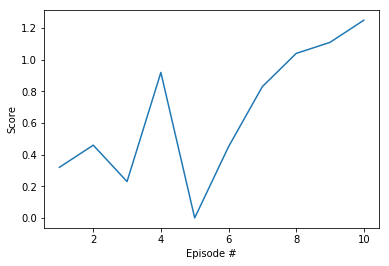

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

OK, let's try running that for a bit longer

In [24]:
hypers = set_up_hyperparameters(n_episodes=300, save_name='test', print_every = 5, actor_fc1_units=128,
                               critic_fcs1_units=128)

In [25]:
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0001
lr_critic 		 0.001
weight_decay 		 0
n_episodes 		 300
max_t 			 1000
print_every 		 5
oun_mu 			 0.0
oun_theta 		 0.15
oun_sigma 		 0.2
actor_fc1_units 	 128
actor_fc2_units 	 128
critic_fcs1_units 	 128
critic_fc2_units 	 128
save_every 		 20
save_name 		 test
load_from_actor 	 
load_from_critic 	 


In [34]:
from workspace_utils import active_session

In [27]:
with active_session():
    scores == ddpg(hypers)

1
Episode 1 of 300	Avg Score: 0.002
Episode 2 of 300	Avg Score: 0.363
Episode 3 of 300	Avg Score: 0.354
Episode 4 of 300	Avg Score: 0.525
Episode 5	Avg Score: 0.74e: 0.74
6
Episode 6 of 300	Avg Score: 0.737
Episode 7 of 300	Avg Score: 0.708
Episode 8 of 300	Avg Score: 0.689
Episode 9 of 300	Avg Score: 0.6910
Episode 10	Avg Score: 0.66e: 0.66
11
Episode 11 of 300	Avg Score: 0.6012
Episode 12 of 300	Avg Score: 0.5513
Episode 13 of 300	Avg Score: 0.5314
Episode 14 of 300	Avg Score: 0.5615
Episode 15	Avg Score: 0.56e: 0.56
16
Episode 16 of 300	Avg Score: 0.5817
Episode 17 of 300	Avg Score: 0.6218
Episode 18 of 300	Avg Score: 0.6619
Episode 19 of 300	Avg Score: 0.7120
Episode 20	Avg Score: 0.75e: 0.75
21
Episode 21 of 300	Avg Score: 0.8122
Episode 22 of 300	Avg Score: 0.7823
Episode 23 of 300	Avg Score: 0.8124
Episode 24 of 300	Avg Score: 0.8125
Episode 25	Avg Score: 0.81e: 0.81
26
Episode 26 of 300	Avg Score: 0.8327
Episode 27 of 300	Avg Score: 0.8528
Episode 28 of 300	Avg Score: 0.8329
Ep

KeyboardInterrupt: 

In [23]:
hypers = set_up_hyperparameters(n_episodes=300, save_name='run2', print_every = 10, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=256)

In [24]:
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 256
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0001
lr_critic 		 0.001
weight_decay 		 0
learn_every 		 5
n_episodes 		 300
max_t 			 1000
print_every 		 10
oun_mu 			 0.0
oun_theta 		 0.15
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run2
load_from_actor 	 
load_from_critic 	 


In [ ]:
with active_session():
    scores == ddpg(hypers)

I actually did run with those parameters for 300 episodes, but didn't save the print-outs. It was very slow learning - getting to only 1.45 average after 300 esisodes. Therefore will try to increase the learning rate for both?

In [32]:
hypers = set_up_hyperparameters(n_episodes=300, save_name='run3', print_every = 20, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 1e-3, lr_critic = 5e-3)

In [33]:
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.001
lr_critic 		 0.005
weight_decay 		 0
learn_every 		 5
n_episodes 		 300
max_t 			 1000
print_every 		 20
oun_mu 			 0.0
oun_theta 		 0.15
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run3
load_from_actor 	 
load_from_critic 	 


In [34]:
with active_session():
    scores == ddpg(hypers)

Episode 20	Avg Score: 0.57e: 0.57
Episode 40	Avg Score: 0.36e: 0.36
Episode 60	Avg Score: 0.25e: 0.25
Episode 80	Avg Score: 0.19e: 0.19
Episode 100	Avg Score: 0.15e: 0.15
Episode 120	Avg Score: 0.04e: 0.04
Episode 140	Avg Score: 0.02e: 0.02
Episode 160	Avg Score: 0.01e: 0.01
Episode 180	Avg Score: 0.01e: 0.01
Episode 200	Avg Score: 0.01e: 0.01
Episode 220	Avg Score: 0.01e: 0.01
Episode 240	Avg Score: 0.01e: 0.01
Episode 260	Avg Score: 0.01e: 0.01
Episode 280	Avg Score: 0.02e: 0.02
Episode 300	Avg Score: 0.02e: 0.02


Well. That was pretty disastrous!   
Next effort - move the learning rates back down to, say 5e-4 each.

In [36]:
hypers = set_up_hyperparameters(n_episodes=300, save_name='run4', print_every = 20, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 5e-4, lr_critic = 5e-4)
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0005
lr_critic 		 0.0005
weight_decay 		 0
learn_every 		 5
n_episodes 		 300
max_t 			 1000
print_every 		 20
oun_mu 			 0.0
oun_theta 		 0.15
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run4
load_from_actor 	 
load_from_critic 	 


In [37]:
with active_session():
    scores == ddpg(hypers)

Episode 20	Avg Score: 0.91e: 0.91
Episode 40	Avg Score: 0.78e: 0.78
Episode 60	Avg Score: 0.58e: 0.58
Episode 80	Avg Score: 0.63e: 0.63
Episode 100	Avg Score: 0.78e: 0.78
Episode 120	Avg Score: 1.07e: 1.07
Episode 140	Avg Score: 1.50e: 1.50
Episode 160	Avg Score: 2.06e: 2.06
Episode 180	Avg Score: 2.57e: 2.57
Episode 200	Avg Score: 3.34e: 3.34
Episode 220	Avg Score: 4.21e: 4.21
Episode 240	Avg Score: 5.24e: 5.24
Episode 260	Avg Score: 5.93e: 5.93
Episode 280	Avg Score: 7.10e: 7.10
Episode 300	Avg Score: 7.68e: 7.68


OK, so at this point, I returned to Udacity website - the session had closed itself down. But the checkpoints had worked, and the weights saved..... but annoyingly I called them the same name, so the critic weights over-rode the actor weights. As it looked like there was some promise to training, I'll fix the code, so that the critic weights are saved also. But I will run the training with more episodes.

In [41]:
hypers = set_up_hyperparameters(n_episodes=1000, save_name='run4', print_every = 20, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 5e-4, lr_critic = 5e-4)
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0005
lr_critic 		 0.0005
weight_decay 		 0
learn_every 		 5
n_episodes 		 1000
max_t 			 1000
print_every 		 20
oun_mu 			 0.0
oun_theta 		 0.15
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run4
save_data_name 		 _data_default
load_from_actor 	 
load_from_critic 	 


In [42]:
with active_session():
    scores == ddpg(hypers)

Episode 20	Avg Score: 0.41re: 0.41
Episode 40	Avg Score: 0.68re: 0.68
Episode 60	Avg Score: 0.64re: 0.64
Episode 80	Avg Score: 0.74re: 0.74
Episode 100	Avg Score: 0.95re: 0.95
Episode 120	Avg Score: 1.30re: 1.30
Episode 140	Avg Score: 1.66re: 1.66
Episode 160	Avg Score: 2.02re: 2.02
Episode 180	Avg Score: 2.46re: 2.46
Episode 200	Avg Score: 2.81re: 2.81
Episode 220	Avg Score: 3.20re: 3.20
Episode 240	Avg Score: 3.78re: 3.78
Episode 260	Avg Score: 4.47re: 4.47
Episode 280	Avg Score: 5.05re: 5.05
Episode 300	Avg Score: 5.78re: 5.78
Episode 320	Avg Score: 6.25re: 6.25
Episode 340	Avg Score: 6.61re: 6.61
Episode 360	Avg Score: 7.11re: 7.11
Episode 380	Avg Score: 7.58re: 7.58
Episode 400	Avg Score: 7.62re: 7.62
Episode 420	Avg Score: 8.04re: 8.04
Episode 440	Avg Score: 8.09re: 8.09
Episode 460	Avg Score: 8.18re: 8.18
Episode 480	Avg Score: 8.23re: 8.23
Episode 500	Avg Score: 8.43re: 8.43
Episode 520	Avg Score: 8.47re: 8.47
Episode 540	Avg Score: 8.51re: 8.51
Episode 560	Avg Score: 8.43re: 8

Hmm, not so good. Try reducing the theta - exploring too much?

In [44]:
hypers = set_up_hyperparameters(n_episodes=300, save_name='run5', print_every = 20, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 5e-4, lr_critic = 5e-4, oun_theta=0.05)
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0005
lr_critic 		 0.0005
weight_decay 		 0
learn_every 		 5
n_episodes 		 300
max_t 			 1000
print_every 		 20
oun_mu 			 0.0
oun_theta 		 0.05
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run5
save_data_name 		 _data_default
load_from_actor 	 
load_from_critic 	 


In [45]:
with active_session():
    scores == ddpg(hypers)

Episode 20	Avg Score: 0.86e: 0.86
Episode 40	Avg Score: 1.02e: 1.02
Episode 60	Avg Score: 1.13e: 1.13
Episode 80	Avg Score: 1.33e: 1.33
Episode 100	Avg Score: 1.71e: 1.71
Episode 120	Avg Score: 2.42e: 2.42
Episode 140	Avg Score: 3.24e: 3.24
Episode 160	Avg Score: 4.54e: 4.54
Episode 180	Avg Score: 5.79e: 5.79
Episode 200	Avg Score: 7.19e: 7.19
Episode 220	Avg Score: 8.52e: 8.52
Episode 240	Avg Score: 10.06: 10.06
Episode 260	Avg Score: 11.11: 11.11
Episode 280	Avg Score: 12.44: 12.44
Episode 300	Avg Score: 13.09: 13.09


Training appears good. Yippee!. Continue training, but with loaded weights.

In [51]:
hypers = set_up_hyperparameters(n_episodes=1000, save_name='run6', print_every = 20, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 5e-4, 
                                lr_critic = 5e-4, oun_theta=0.05)
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0005
lr_critic 		 0.0005
weight_decay 		 0
learn_every 		 5
n_episodes 		 1000
max_t 			 1000
print_every 		 20
oun_mu 			 0.0
oun_theta 		 0.05
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run6
save_data_name 		 _data_default
load_from_actor 	 
load_from_critic 	 


In [52]:
with active_session():
    scores_2 = ddpg(hypers)

Episode 20	Avg Score: 0.39re: 0.39
Episode 40	Avg Score: 0.21re: 0.21
Episode 60	Avg Score: 0.23re: 0.23
Episode 80	Avg Score: 0.29re: 0.29
Episode 100	Avg Score: 0.38re: 0.38
Episode 120	Avg Score: 0.52re: 0.52
Episode 140	Avg Score: 0.82re: 0.82
Episode 160	Avg Score: 1.12re: 1.12
Episode 180	Avg Score: 1.41re: 1.41
Episode 200	Avg Score: 1.69re: 1.69
Episode 220	Avg Score: 1.86re: 1.86
Episode 240	Avg Score: 2.20re: 2.20
Episode 260	Avg Score: 2.51re: 2.51
Episode 280	Avg Score: 2.74re: 2.74
Episode 300	Avg Score: 3.10re: 3.10
Episode 320	Avg Score: 3.41re: 3.41
Episode 340	Avg Score: 3.64re: 3.64
Episode 360	Avg Score: 3.78re: 3.78
Episode 380	Avg Score: 3.99re: 3.99
Episode 400	Avg Score: 4.01re: 4.01
Episode 420	Avg Score: 4.17re: 4.17
Episode 440	Avg Score: 4.41re: 4.41
Episode 460	Avg Score: 4.74re: 4.74
Episode 480	Avg Score: 5.35re: 5.35
Episode 500	Avg Score: 5.99re: 5.99
Episode 520	Avg Score: 6.87re: 6.87
Episode 540	Avg Score: 7.40re: 7.40
Episode 560	Avg Score: 8.05re: 8

Those results looked good - just not enough time. I might tweak the learning rate slightly higher, but otherwise let it run for longer.  I also added code to pickle the data in stages so we can graph it, even if the connection with the server is lost.

In [35]:
hypers = set_up_hyperparameters(n_episodes=2000, save_name='run7', print_every = 20, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 8e-4, 
                                lr_critic = 8e-4, oun_theta=0.05, save_data_name='run7_data_')
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0008
lr_critic 		 0.0008
weight_decay 		 0
learn_every 		 5
n_episodes 		 2000
max_t 			 1000
print_every 		 20
oun_mu 			 0.0
oun_theta 		 0.05
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run7
save_data_name 		 run7_data_
load_from_actor 	 
load_from_critic 	 


In [36]:
with active_session():
    scores = ddpg(hypers)

Episode 20	Avg Score: 0.11re: 0.11
Episode 40	Avg Score: 0.06re: 0.06
Episode 60	Avg Score: 0.13re: 0.13
Episode 80	Avg Score: 0.19re: 0.19
Episode 100	Avg Score: 0.24re: 0.24
Episode 120	Avg Score: 0.39re: 0.39
Episode 140	Avg Score: 0.53re: 0.53
Episode 160	Avg Score: 0.63re: 0.63
Episode 180	Avg Score: 0.66re: 0.66
Episode 200	Avg Score: 0.72re: 0.72
Episode 220	Avg Score: 0.68re: 0.68
Episode 240	Avg Score: 0.69re: 0.69
Episode 260	Avg Score: 0.70re: 0.70
Episode 280	Avg Score: 0.73re: 0.73
Episode 300	Avg Score: 0.69re: 0.69
Episode 320	Avg Score: 0.76re: 0.76
Episode 340	Avg Score: 0.78re: 0.78
Episode 360	Avg Score: 0.83re: 0.83
Episode 380	Avg Score: 0.86re: 0.86
Episode 400	Avg Score: 0.98re: 0.98
Episode 420	Avg Score: 0.98re: 0.98
Episode 440	Avg Score: 0.99re: 0.99
Episode 460	Avg Score: 0.96re: 0.96
Episode 480	Avg Score: 1.01re: 1.01
Episode 500	Avg Score: 0.97re: 0.97
Episode 520	Avg Score: 0.99re: 0.99
Episode 540	Avg Score: 0.90re: 0.90
Episode 560	Avg Score: 0.87re: 0

Did not work - revert the learning rate back down (even lower). And re-try....

In [38]:
hypers = set_up_hyperparameters(n_episodes=2000, save_name='run8', print_every = 50, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 3e-4, 
                                lr_critic = 3e-4, oun_theta=0.05, save_data_name='run8_data_')
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0003
lr_critic 		 0.0003
weight_decay 		 0
learn_every 		 5
n_episodes 		 2000
max_t 			 1000
print_every 		 50
oun_mu 			 0.0
oun_theta 		 0.05
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run8
save_data_name 		 run8_data_
load_from_actor 	 
load_from_critic 	 


In [39]:
with active_session():
    scores = ddpg(hypers)

Episode 50	Avg Score: 0.60re: 0.60
Episode 100	Avg Score: 0.93re: 0.93
Episode 150	Avg Score: 2.27re: 2.27
Episode 200	Avg Score: 5.19re: 5.19
Episode 250	Avg Score: 10.22e: 10.22
Episode 300	Avg Score: 17.37e: 17.37
Episode 350	Avg Score: 25.14e: 25.14
Episode 380 of 2000	Avg Score: 30.21Task completed on episode 380


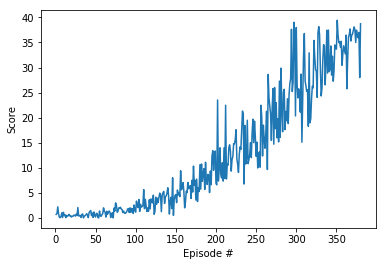

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [42]:
plt.savefig('solved.jpg')

Well, that was a bit easy - can see if I can get a higher score now? Changed the code in ddpg to get a score > 40 as a success measure.  
The *only* change in the ddpg code below is the use of a score-target now, instead of hard-coded figure of 30

In [43]:
def ddpg(hypers, score_target=30):
    """Run the DDPG agent through episodes, using Actor and Critic"""
    
    agent = Agent(hypers=hypers)
    if hypers['load_from_actor']:
        agent.actor_local.load_state_dict(hypers['load_from_actor'])
        
    if hypers['load_from_critic']:
        agent.critic_local.load_state_dict(hypers['load_from_critic'])
    
    n_episodes = hypers['n_episodes']
    max_t = hypers['max_t']
    print_every = hypers['print_every']
    save_every = hypers['save_every']
    check_point_actor = 'checkpoint_actor_' + hypers['save_name']+'_'
    check_point_critic = 'checkpoint_critic_' + hypers['save_name']+'_'
    scores_deque = deque(maxlen = 100) # this is the test we are using - have to get avg > 30 over 100 episodes
    scores=[]
    epsilon = 1
    for i_episode in range(1, n_episodes +1):
        env_info = env.reset(train_mode=True)[brain_name]
        state =env_info.vector_observations
        agent.reset() # note - this resets the noise only!
#         epsilon *= EPSILON_RATE
        
        score=0
        while True:
#         for t in range(max_t):
            action = agent.act(state, epsilon)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward[0]
            if done[0]:
                break
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {} of {}\tAvg Score: {:.2f}'.format(i_episode, n_episodes, np.mean(scores_deque)), end="")
        if i_episode % save_every == 0:
            torch.save(agent.actor_local.state_dict(), check_point_actor + str(i_episode))
            torch.save(agent.critic_local.state_dict(), check_point_critic + str(i_episode))
            with open(hypers['save_data_name']+'.pkl', 'wb') as file:
                pickle.dump(scores, file)
        if i_episode % print_every == 0:
                print('\rEpisode {}\tAvg Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > score_target:
            print ('Task completed on episode {}'.format(i_episode))
            torch.save(agent.actor_local.state_dict(), check_point_actor + '_SOLVED')
            torch.save(agent.critic_local.state_dict(), check_point_critic + '_SOLVED')
            with open(hypers['save_data_name']+'.pkl', 'wb') as file:
                pickle.dump(scores, file)
            break
    return scores

In [44]:
hypers = set_up_hyperparameters(n_episodes=2000, save_name='run9', print_every = 50, actor_fc1_units=256,
                               critic_fcs1_units=256, batch_size=128, lr_actor = 3e-4, 
                                lr_critic = 3e-4, oun_theta=0.05, save_data_name='run8_data_')
pprint(hypers)

Hyper-parameters used
state_size 		 33
action_size 		 4
random_seed 		 101
buffer_size 		 100000
batch_size 		 128
gamma 			 0.99
tau 			 0.001
lr_actor 		 0.0003
lr_critic 		 0.0003
weight_decay 		 0
learn_every 		 5
n_episodes 		 2000
max_t 			 1000
print_every 		 50
oun_mu 			 0.0
oun_theta 		 0.05
oun_sigma 		 0.2
actor_fc1_units 	 256
actor_fc2_units 	 128
critic_fcs1_units 	 256
critic_fc2_units 	 128
save_every 		 20
save_name 		 run9
save_data_name 		 run8_data_
load_from_actor 	 
load_from_critic 	 


In [45]:
with active_session():
    scores = ddpg(hypers, score_target=40)

Episode 50	Avg Score: 0.63re: 0.63
Episode 100	Avg Score: 1.10re: 1.10
Episode 150	Avg Score: 2.13re: 2.13
Episode 200	Avg Score: 3.77re: 3.77
Episode 250	Avg Score: 6.67re: 6.67
Episode 300	Avg Score: 9.06re: 9.06
Episode 350	Avg Score: 10.46e: 10.46
Episode 400	Avg Score: 10.96e: 10.96
Episode 450	Avg Score: 10.84e: 10.84
Episode 500	Avg Score: 11.25e: 11.25
Episode 550	Avg Score: 11.58e: 11.58
Episode 600	Avg Score: 10.75e: 10.75
Episode 650	Avg Score: 10.22e: 10.22
Episode 700	Avg Score: 10.64e: 10.64
Episode 750	Avg Score: 11.32e: 11.32
Episode 800	Avg Score: 11.95e: 11.95
Episode 850	Avg Score: 12.16e: 12.16
Episode 900	Avg Score: 13.09e: 13.09
Episode 950	Avg Score: 13.78e: 13.78
Episode 1000	Avg Score: 14.35e: 14.35
Episode 1050	Avg Score: 15.17e: 15.17
Episode 1100	Avg Score: 16.06e: 16.06
Episode 1150	Avg Score: 16.70e: 16.70
Episode 1200	Avg Score: 16.97e: 16.97
Episode 1250	Avg Score: 19.36e: 19.36
Episode 1300	Avg Score: 22.38e: 22.38
Episode 1350	Avg Score: 25.33e: 25.33
